In [1]:
import flwr as fl
import torch
from omegaconf import OmegaConf, DictConfig
from matplotlib import pyplot as plt

from common.interface import aggregate_weighted_average
from gorila import create_dqn_client


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_CLIENTS = 10

/home/markhaoxiang/Projects/fl/gym_flower_rl/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-02-23 22:33:54,628	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [11]:
# Define Config
config = DictConfig({
    "rl": {
        "env": {
            "name": "CartPole-v1"
        },
        "algorithm": {
            "type": "ddpg",
            "gamma": 0.99,
            "tau": 0.005,
            "lr": 0.001,
            "update_frequency": 1,
            "clip_grad_norm": 1,
            "critic": {
                "features": 64
            }
        },
        "memory": {
            "type": "experience_replay",
            "capacity": 20000
        },
        "train": {
            "initial_collection_size": 512,
            "minibatch_size": 32
        }
    },
    "fl": {
        "train_config": {
            "frames": 1000,
        },
        "evaluate_config": {
            "evaluation_repeats": 1 
        }
    }
})

train_config = OmegaConf.to_container(config["fl"]["train_config"])
evaluate_config = OmegaConf.to_container(config["fl"]["evaluate_config"])

def _on_fit_config_fn(server_round: int):
    return train_config | {"server_round": server_round}
def _on_evaluate_config_fn(server_round: int):
    return evaluate_config | {"server_round": server_round}

In [15]:
strategy = fl.server.strategy.FedAvg(
    on_fit_config_fn = _on_fit_config_fn,
    on_evaluate_config_fn= _on_evaluate_config_fn,
    fit_metrics_aggregation_fn=aggregate_weighted_average,
    evaluate_metrics_aggregation_fn=aggregate_weighted_average, 
    accept_failures=False
)

hist = fl.simulation.start_simulation(
    client_fn=lambda cid: create_dqn_client(int(cid), config=config).to_client(),
    client_resources={'num_cpus': 1},
    config=fl.server.ServerConfig(num_rounds=100),
    num_clients = 10,
    strategy = strategy
)

INFO flwr 2024-02-23 22:41:04,896 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=100, round_timeout=None)
2024-02-23 22:41:08,127	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-02-23 22:41:08,682 | app.py:213 | Flower VCE: Ray initialized with resources: {'CPU': 20.0, 'memory': 11067435419.0, 'accelerator_type:G': 1.0, 'GPU': 1.0, 'node:__internal_head__': 1.0, 'node:10.110.0.26': 1.0, 'object_store_memory': 5533717708.0}
INFO flwr 2024-02-23 22:41:08,682 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-02-23 22:41:08,682 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1}
INFO flwr 2024-02-23 22:41:08,689 | app.py:288 | Flower VCE: Creating VirtualClientEngineActorPool with 20 actors
INFO flwr 2024-02-23 22:41:08,689 | server.py:89 | Initializing global parameters
INFO flwr 2024-02-23 22:41:08,689 | server.py:276 | Requesting i

KeyboardInterrupt: 

Text(0.5, 0, 'Round')

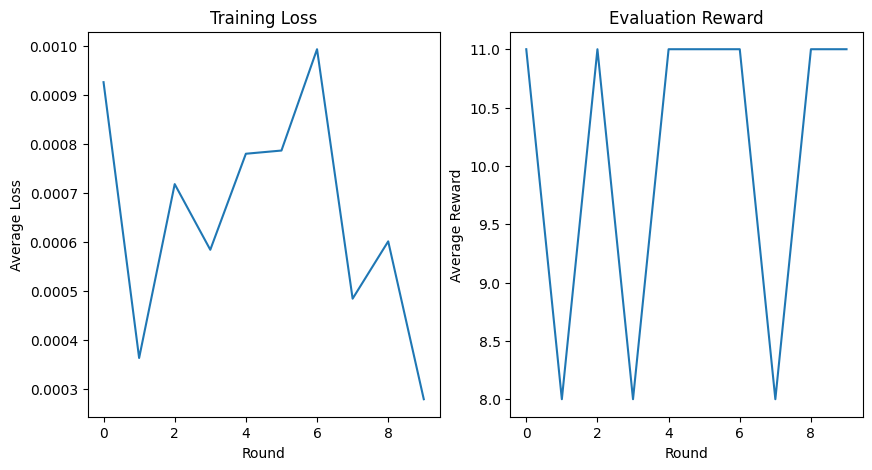

In [14]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(10,5)

# TODO: Confidence bounds

# Loss
ax = axs[0]
ax.plot([x[1]['avg'] for x in hist.metrics_distributed_fit['loss']])
ax.set_title("Training Loss")
ax.set_ylabel("Average Loss")
ax.set_xlabel("Round")

# Evaluate reward
ax = axs[1]
ax.plot([x[1]['avg'] for x in hist.metrics_distributed['reward']])
ax.set_title("Evaluation Reward")
ax.set_ylabel("Average Reward")
ax.set_xlabel("Round")